# Introduction to Digital Forensics - Assignment 3
### 1


### 2

### 3


### Made by group 1:
- Simge Bilen       s2532239
- Mark Boom         s2552469
- Tom Essers        s2484765
- Baran Gülbey      s2616394
- Jelmer Hofman     s2460653
- Stijn Schuurman   s2620162

In [1]:
!pip3 install pandas
!pip3 install matplotlib
!pip3 install openpyxl

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#csv file
file =  'jabber_chat_2021_2022_translated.csv'

df = pd.read_csv(file)
test = ""
len(test)

0

(array([ 313.,  408.,  321.,  388.,  249.,  531.,  839., 1977., 2759.,
        3221., 3200., 3582., 4503., 5233., 5257., 4545., 4723., 4946.,
        4393., 3089., 2940., 1952., 1404.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23.]),
 <BarContainer object of 23 artists>)

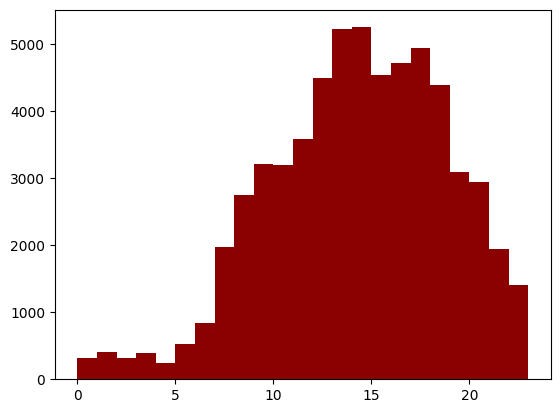

In [4]:
df = pd.read_csv(file, usecols=['ts'])
hours = []
for index, row in df.iterrows():
    hours.append(int(row.ts[11:13]))
plt.hist(hours, color="darkred", bins=range(0, 24))

In [43]:
def walletFinder(stringOfCell):
    cryptoBegin = ["1", "3", "b"]
    splittedCell = stringOfCell.split(' ')
    for word in splittedCell:
        if len(word) > 0:
            if word[0] in cryptoBegin:
                if len(word) in range(31, 35):
                    return word
    return 0
    
                
# officieel tussen 27 en 34 length bitcoin wallet

In [47]:
df = pd.read_csv(file, usecols=['body'])
errorStrings = ["[ERROR: This message is encrypted, and you are unable to decrypt it.]", "[Ошибка: сообщение зашифровано, и невозможно его расшифровать.]"]
publicKeyString = "-----BEGIN PGP PUBLIC KEY BLOCK-----"
onionString = ".onion"
wallets = []
for index, row in df.iterrows():
    if row.body not in errorStrings:
        if publicKeyString not in row.body:
            if onionString not in row.body:
                temp = walletFinder(row.body)
                if temp != 0:
                    if temp not in wallets:
                        wallets.append(temp)
print(wallets)



['3ESoHHu87mTrFNSNUaMVEfT3vYwRYGfSHQ', '1PemRXvQ5nbDs6q19pCUzfd4kXVGovVoe3', '14HnaQfsQdtgVSNR91jLcbcKtdyddDfP6D', '15gjb8F5Zd8XRKBCgVxsr8ZuVzr7yBtnCN', '1DSp4woswZECAL9zdmmGeu1s7k1sGExFDh', '192.168.86.23(Preferred)\r\nSubnet', '1HtyXyCrshiJmLYNru7atpDMJrzG9mzwzf', 'b58c7d4c1824eefc874dd7f07eacec58', '1KfDPgc6CiWb6Fnin1bLWi2moX1ViXANxW', '1AXiwETqqQoA52Jk5CmJkbAPuW8nR7VUYz', '1hLvH27BxAPbqx3R2fMCuuMPfS2gGDBJL', '3N4oho2uXfkFBfUAPtoPGLUXjHXqXV4vrJ', '1347fBtFzZCrPq29yjRpct5f6Kq5uHZHHy', '36UqDj8hGfZTVjpURvSnKtpJnJKjhYcvuY', '314f41b2d78ec803c74a2c89fa8e8bb4', '31inPQPChryvSPEnaXrBc6kmYH4NAqYnTR', '1DS9DVVD4K86ppQhg8ta9XFVEaaW7NXZfA', '12V63PHiX8FvEgyewX5W1D2QrdJJSawqQM', '1HFqLt3fbuewZe5ncJautgncS6hN1ZzX5r', '16evvEiZ6HKkV9WAbysJfJG1Qa7DzJGUFp', '172KVKhMqL5CU1HN884RbArzu5DDL5hwE3', '1LYiEgq9k3xSAddbqMZcsVTayJVoKbTFub', '3A8xNfeK2dXdDHi5PtKjZFa48HFixTqdAv', '36dmB68ZpeZZThy9SnCHoMvfqCKgZS1Grf', 'b0f6d9a083596b0fd4f9168d6f3d67cc', '112qJRWfQCAqKzSk3ZcQnq1A1YwqyfLbgp', '3Jc3mTyYuRpP7hynP